### Install PySpark

In [1]:
!pip install pyspark

### Initializing SparkSession

In [2]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Life Expectancy") \
    .getOrCreate()

### Importing Packages

In [3]:
# Import packages
from pyspark.sql.functions import col, isnan, when, count
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.ml.feature import VectorAssembler, PolynomialExpansion
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

### Loading Life Expectancy CSV file

In [4]:
# Define the path to your CSV file
csv_path = 'LifeExpectancy.csv'

# Load the CSV file into a DataFrame
df = spark.read.csv(csv_path, header=True, inferSchema=True)

# Show the first few rows of the DataFrame
df.show(5)

+-----------+----+----------+---------------+---------------+-------------+-------+----------------------+-----------+--------+-----+------------------+-----+-----------------+-----------+---------+----------+-----------+---------------------+-------------------+-------------------------------+---------+
|    Country|Year|    Status|Life expectancy|Adult Mortality|infant deaths|Alcohol|percentage expenditure|Hepatitis B|Measles | BMI |under-five deaths |Polio|Total expenditure|Diphtheria | HIV/AIDS|       GDP| Population| thinness  1-19 years| thinness 5-9 years|Income composition of resources|Schooling|
+-----------+----+----------+---------------+---------------+-------------+-------+----------------------+-----------+--------+-----+------------------+-----+-----------------+-----------+---------+----------+-----------+---------------------+-------------------+-------------------------------+---------+
|Afghanistan|2015|Developing|           65.0|            263|           62|   0.01

### Preprocessing and EDA

In [5]:
# Print the schema of the DataFrame
df.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- Life expectancy: double (nullable = true)
 |-- Adult Mortality: integer (nullable = true)
 |-- infant deaths: integer (nullable = true)
 |-- Alcohol: double (nullable = true)
 |-- percentage expenditure: double (nullable = true)
 |-- Hepatitis B: integer (nullable = true)
 |-- Measles : integer (nullable = true)
 |--  BMI : double (nullable = true)
 |-- under-five deaths : integer (nullable = true)
 |-- Polio: integer (nullable = true)
 |-- Total expenditure: double (nullable = true)
 |-- Diphtheria : integer (nullable = true)
 |--  HIV/AIDS: double (nullable = true)
 |-- GDP: double (nullable = true)
 |-- Population: double (nullable = true)
 |--  thinness  1-19 years: double (nullable = true)
 |--  thinness 5-9 years: double (nullable = true)
 |-- Income composition of resources: double (nullable = true)
 |-- Schooling: double (nullable = true)



In [6]:
# Get basic statistics for numerical columns
df.describe().show()

+-------+-----------+-----------------+----------+-----------------+------------------+------------------+-----------------+----------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+--------------------+---------------------+-------------------+-------------------------------+------------------+
|summary|    Country|             Year|    Status|  Life expectancy|   Adult Mortality|     infant deaths|          Alcohol|percentage expenditure|       Hepatitis B|          Measles |              BMI |under-five deaths |            Polio| Total expenditure|       Diphtheria |          HIV/AIDS|               GDP|          Population| thinness  1-19 years| thinness 5-9 years|Income composition of resources|         Schooling|
+-------+-----------+-----------------+----------+-----------------+------------------+------------------+-----------------+------------

In [7]:
# Count the number of rows
print(f"Number of rows: {df.count()}")

# Count the number of columns
print(f"Number of columns: {len(df.columns)}")

Number of rows: 2928
Number of columns: 22


In [8]:
# Show column names
print(f"Column names: {df.columns}")

Column names: ['Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years', ' thinness 5-9 years', 'Income composition of resources', 'Schooling']


In [9]:
# Check for missing values
df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns]).show()

+-------+----+------+---------------+---------------+-------------+-------+----------------------+-----------+--------+-----+------------------+-----+-----------------+-----------+---------+---+----------+---------------------+-------------------+-------------------------------+---------+
|Country|Year|Status|Life expectancy|Adult Mortality|infant deaths|Alcohol|percentage expenditure|Hepatitis B|Measles | BMI |under-five deaths |Polio|Total expenditure|Diphtheria | HIV/AIDS|GDP|Population| thinness  1-19 years| thinness 5-9 years|Income composition of resources|Schooling|
+-------+----+------+---------------+---------------+-------------+-------+----------------------+-----------+--------+-----+------------------+-----+-----------------+-----------+---------+---+----------+---------------------+-------------------+-------------------------------+---------+
|      0|   0|     0|              0|              0|            0|    193|                     0|        553|       0|   32|     

In [10]:
# Dropping null values
df = df.dropna()
df.count()

1649

In [11]:
# Group by 'Country' and get the average life expectancy
df.groupBy("Country").avg("Life expectancy").show()

+-----------+--------------------+
|    Country|avg(Life expectancy)|
+-----------+--------------------+
|       Chad|   52.28571428571429|
|   Paraguay|   72.84166666666667|
|    Senegal|   63.78181818181818|
| Cabo Verde|   72.62307692307692|
|     Sweden|   81.89999999999999|
|   Kiribati|   65.07333333333332|
|     Guyana|   65.61428571428571|
|    Eritrea|  61.089999999999996|
|Philippines|   67.51333333333332|
|   Djibouti|              62.725|
|      Tonga|   72.46666666666665|
|   Malaysia|   73.67333333333335|
|       Fiji|   68.63333333333331|
|     Turkey|   73.78666666666668|
|     Malawi|   50.26153846153847|
|       Iraq|   70.39090909090909|
|    Germany|   81.18666666666667|
|    Comoros|   61.94166666666667|
|Afghanistan|  58.193749999999994|
|   Cambodia|   66.43333333333334|
+-----------+--------------------+
only showing top 20 rows



In [12]:
df.count()

1649

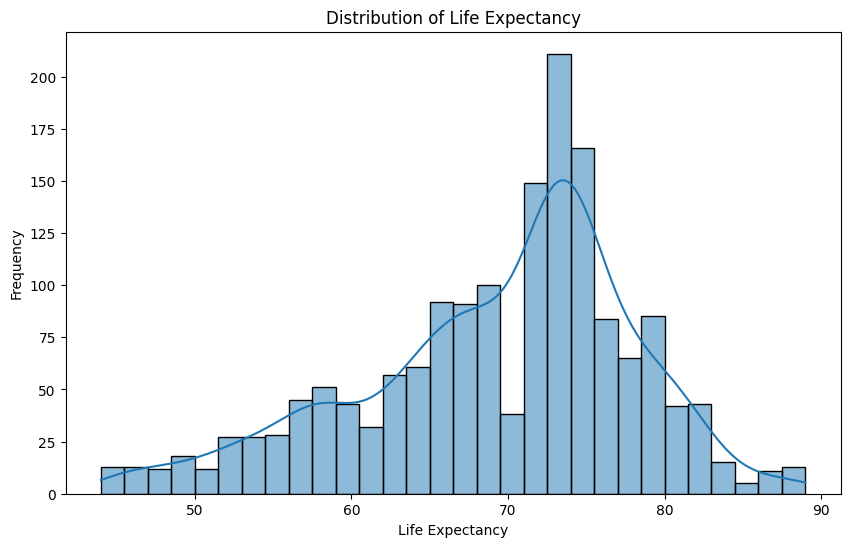

In [13]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
pandas_df = df.toPandas()

# Plot the distribution of life expectancy
plt.figure(figsize=(10, 6))
sns.histplot(pandas_df['Life expectancy'], bins=30, kde=True)
plt.title('Distribution of Life Expectancy')
plt.xlabel('Life Expectancy')
plt.ylabel('Frequency')
plt.show()

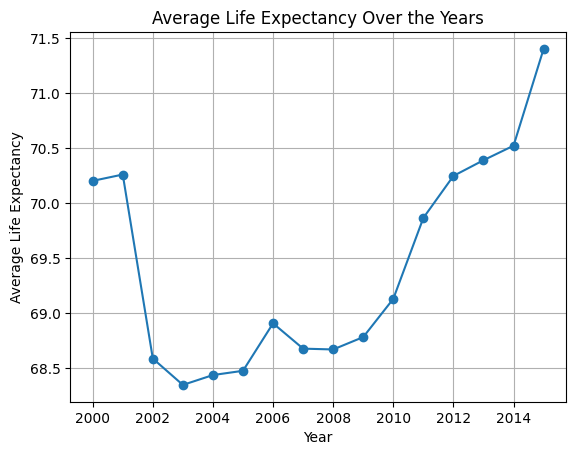

In [14]:
# Group by Year and calculate the average life expectancy
avg_life_expectancy = df.groupBy("Year").mean("Life expectancy").orderBy("Year")

# Convert to Pandas DataFrame for plotting
avg_life_expectancy_pdf = avg_life_expectancy.toPandas()

# Plot the average life expectancy over the years
plt.plot(avg_life_expectancy_pdf["Year"], avg_life_expectancy_pdf["avg(Life expectancy)"], marker='o')
plt.xlabel('Year')
plt.ylabel('Average Life Expectancy')
plt.title('Average Life Expectancy Over the Years')
plt.grid(True)
plt.show()

+-----------+--------------------+
|Country    |avg(Life expectancy)|
+-----------+--------------------+
|Ireland    |83.44               |
|Canada     |82.23333333333333   |
|France     |82.20666666666666   |
|Italy      |82.15333333333334   |
|Spain      |82.02               |
|Australia  |81.90714285714286   |
|Sweden     |81.89999999999999   |
|Austria    |81.47999999999998   |
|Netherlands|81.325              |
|Greece     |81.23333333333333   |
+-----------+--------------------+
only showing top 10 rows



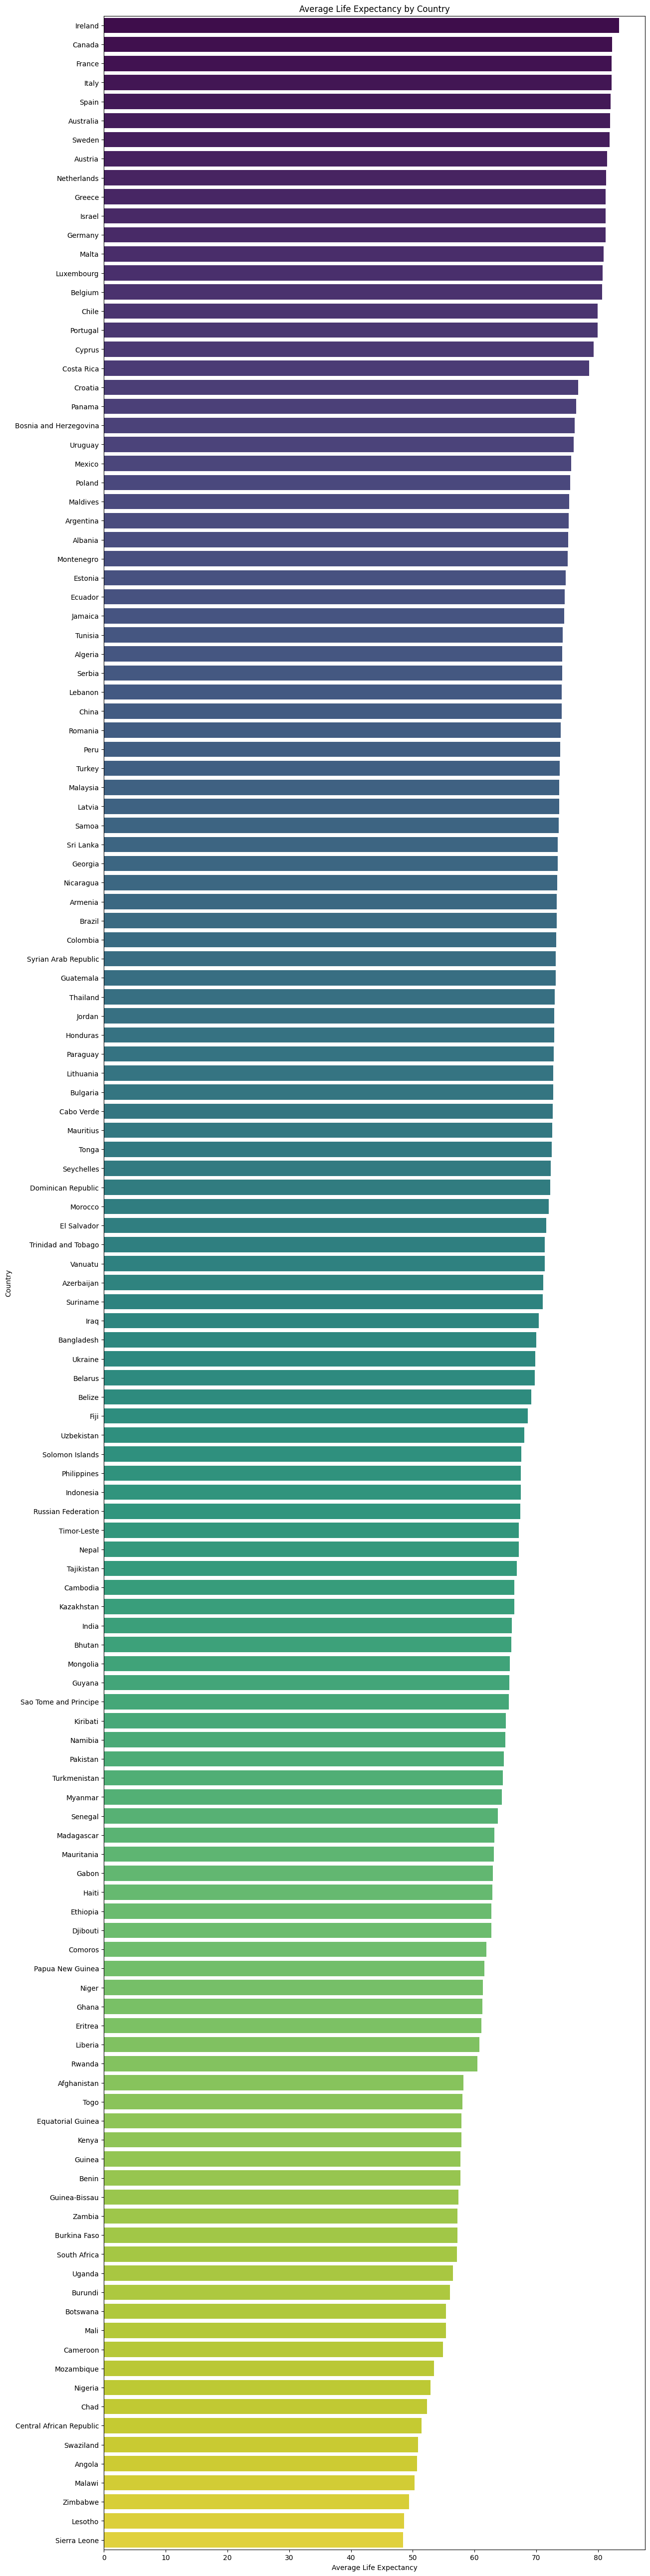

In [15]:
# Group by Country and calculate the average life expectancy
avg_life_expectancy_by_country = df.groupBy("Country").mean("Life expectancy").orderBy("avg(Life expectancy)", ascending=False)

# Show the top 10 countries with the highest average life expectancy
avg_life_expectancy_by_country.show(10, truncate=False)

# Convert to Pandas DataFrame for plotting
avg_life_expectancy_by_country_pdf = avg_life_expectancy_by_country.toPandas()

# Set the figure size for the plot
plt.figure(figsize=(14, len(avg_life_expectancy_by_country_pdf) // 2))

# Plot the average life expectancy by country as a bar graph
sns.barplot(x="avg(Life expectancy)", hue="Country", data=avg_life_expectancy_by_country_pdf, palette="viridis", legend=False, y="Country")

# Add labels and title
plt.xlabel('Average Life Expectancy')
plt.ylabel('Country')
plt.title('Average Life Expectancy by Country')

# Show the plot
plt.show()

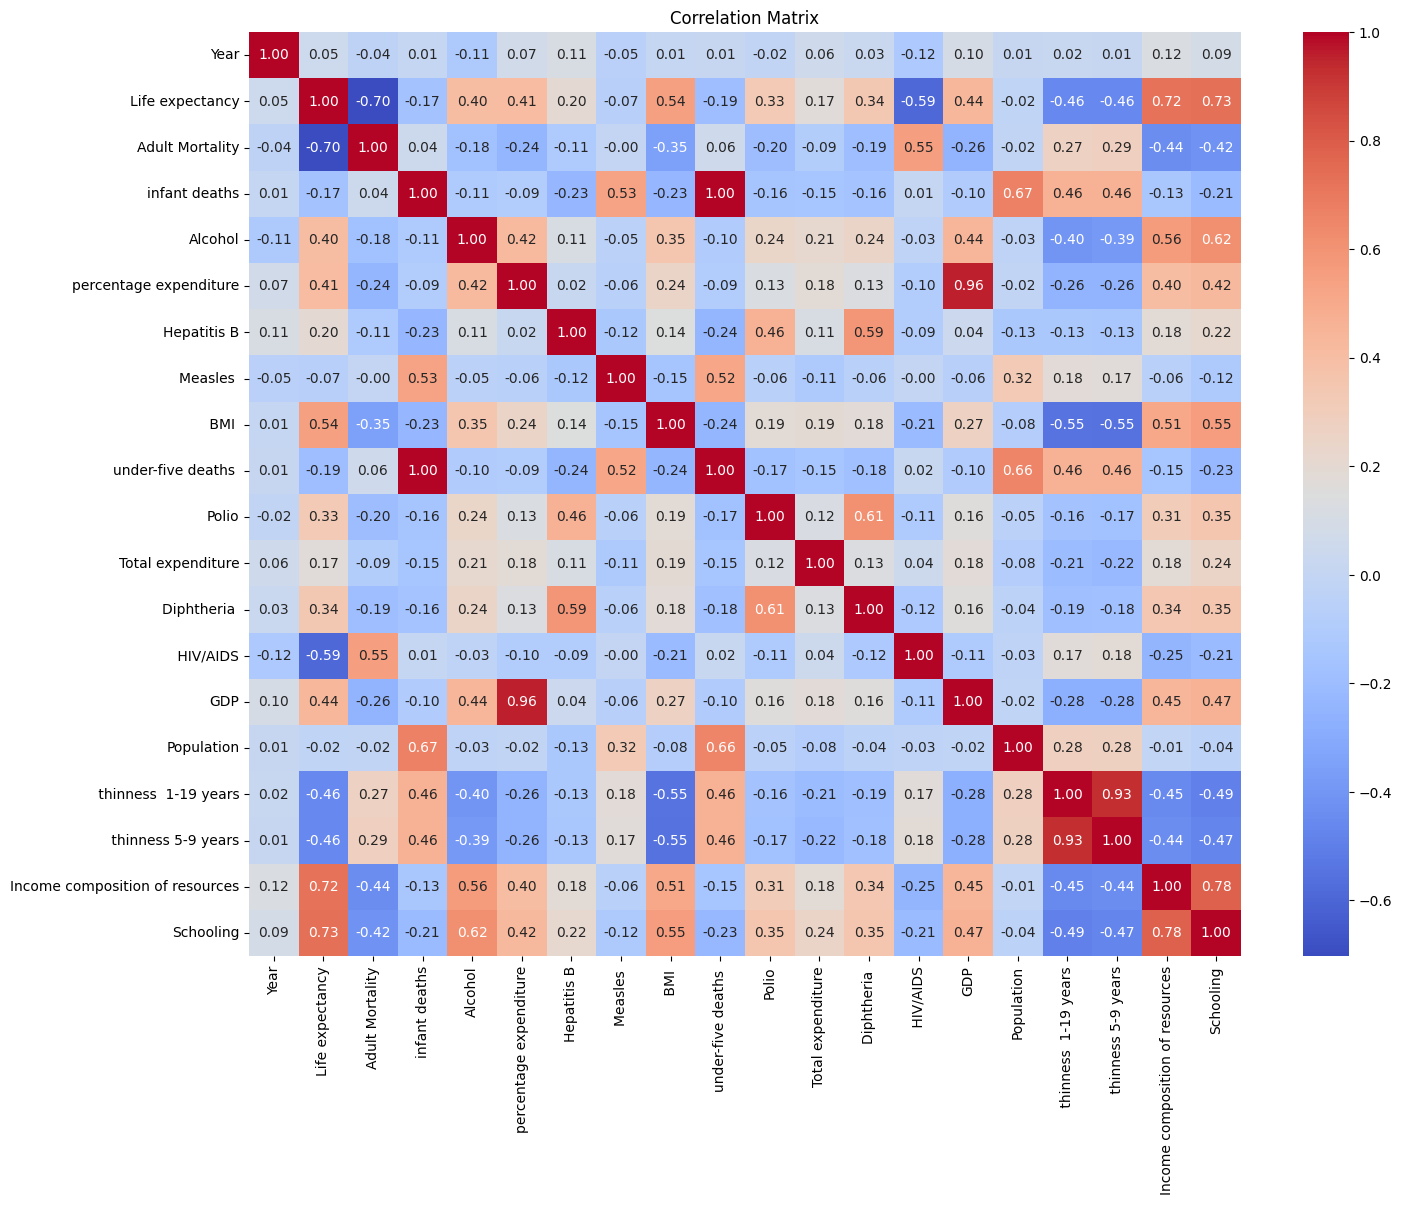

In [16]:
# Select only numeric columns
numeric_df = pandas_df.select_dtypes(include=[int, float])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Display the correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Feature Importance

Feature Importances (sorted):
Income composition of resources: 0.2505461989509171
 HIV/AIDS: 0.1992032574724293
Adult Mortality: 0.1870613186890202
Schooling: 0.1020029447498597
 BMI : 0.09771170338651988
 thinness 5-9 years: 0.06937516508862776
 thinness  1-19 years: 0.03450453831330706
under-five deaths : 0.014388372372794658
Diphtheria : 0.011728482822823634
infant deaths: 0.007634123623287287
GDP: 0.006943275411954776
Alcohol: 0.006252690531922508
Polio: 0.004308651679286469
Total expenditure: 0.004118084757168577
Measles : 0.0015480596241630989
Population: 0.001059331774121122
percentage expenditure: 0.0009791826085663187
Hepatitis B: 0.0006346181432303597


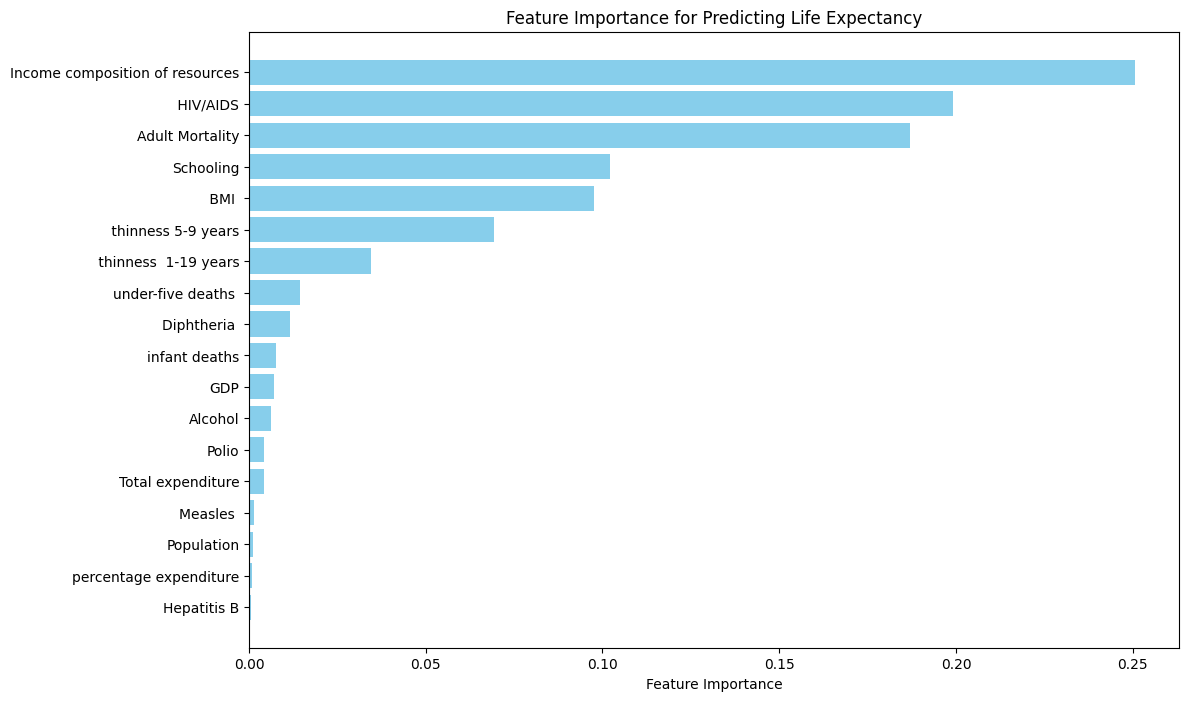

In [17]:
# Select numerical columns for feature selection
numerical_features = ["Adult Mortality", "infant deaths", "Alcohol", "percentage expenditure", "Hepatitis B",
                      "Measles ", " BMI ", "under-five deaths ", "Polio", "Total expenditure",
                      "Diphtheria ", " HIV/AIDS", "GDP", "Population", " thinness  1-19 years",
                      " thinness 5-9 years", "Income composition of resources", "Schooling"]

# Vectorize features
assembler = VectorAssembler(inputCols=numerical_features, outputCol="features")
df_vectorized = assembler.transform(df).select("features", "Life expectancy")

# Initialize a Random Forest Regressor model
rf = RandomForestRegressor(featuresCol="features", labelCol="Life expectancy")

# Fit the model
model = rf.fit(df_vectorized)

# Extract feature importances
importances = model.featureImportances.toArray()

# Get feature names
feature_names = np.array(numerical_features)

# Combine feature names and importances, then sort by importance descending
feature_importances = list(zip(feature_names, importances))
feature_importances_sorted = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# Print feature importances in sorted order
print("Feature Importances (sorted):")
for feat, importance in feature_importances_sorted:
    print(f"{feat}: {importance}")

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh([feat for feat, _ in feature_importances_sorted], [imp for _, imp in feature_importances_sorted], align='center', color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Predicting Life Expectancy')
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
plt.show()

### Feature Selection based on Important Scores

In [18]:
# Set a threshold for feature importance (adjust as needed)
threshold = 0.007  # Example threshold value

# Select features above the threshold
selected_features = [feat for feat, importance in feature_importances_sorted if importance >= threshold]

# Print selected features
print(f"Selected Features (importance >= {threshold}):")
for feat in selected_features:
    print(feat)

# Create a new DataFrame with only the selected features
selected_feature_names = [col(feat) for feat in selected_features]
df_selected_features = df.select(selected_feature_names + ["Life expectancy"])

# Show sample rows of the new DataFrame
df_selected_features.show(5)

Selected Features (importance >= 0.007):
Income composition of resources
 HIV/AIDS
Adult Mortality
Schooling
 BMI 
 thinness 5-9 years
 thinness  1-19 years
under-five deaths 
Diphtheria 
infant deaths
+-------------------------------+---------+---------------+---------+-----+-------------------+---------------------+------------------+-----------+-------------+---------------+
|Income composition of resources| HIV/AIDS|Adult Mortality|Schooling| BMI | thinness 5-9 years| thinness  1-19 years|under-five deaths |Diphtheria |infant deaths|Life expectancy|
+-------------------------------+---------+---------------+---------+-----+-------------------+---------------------+------------------+-----------+-------------+---------------+
|                          0.479|      0.1|            263|     10.1| 19.1|               17.3|                 17.2|                83|         65|           62|           65.0|
|                          0.476|      0.1|            271|     10.0| 18.6|       

### Model Building and Evaluation

### RandomForest Regressor

In [19]:
# Vectorize features
assembler = VectorAssembler(inputCols=[col for col in df_selected_features.columns if col != "Life expectancy"],
                            outputCol="features")
df_vectorized_features = assembler.transform(df_selected_features)

# Split the data into training and testing sets
train, test = df_vectorized_features.randomSplit([0.7, 0.3], seed=42)

# Define the Random Forest Regressor model
rf = RandomForestRegressor(featuresCol="features", labelCol="Life expectancy")

# Define the evaluator for regression
evaluator = RegressionEvaluator(labelCol="Life expectancy", metricName="rmse")

# Build parameter grid for hyperparameter tuning
param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 150]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

# Initialize CrossValidator with the Random Forest Regressor, evaluator, and parameter grid
cv = CrossValidator(estimator=rf,
                    estimatorParamMaps=param_grid,
                    evaluator=evaluator,
                    numFolds=5)

# Fit CrossValidator to training data
cv_model = cv.fit(train)

# Make predictions on test data
predictions = cv_model.transform(test)

# Calculate accuracy metrics based on your criteria
threshold = 5
accurate_predictions = predictions.filter(
    (col("prediction") >= col("Life expectancy") - threshold) & 
    (col("prediction") <= col("Life expectancy") + threshold)
).count()
total_predictions = predictions.count()
accuracy = accurate_predictions / total_predictions * 100
print(f"Accuracy within {threshold} years: {accuracy:.2f}%")

Accuracy within 5 years: 96.62%


In [20]:
# Evaluate the model on test data using RMSE
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")

# Print other evaluation metrics
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print(f"Mean Absolute Error (MAE) on test data: {mae}")
print(f"R-squared (R2) on test data: {r2}")

Root Mean Squared Error (RMSE) on test data: 1.9108355561817163
Mean Absolute Error (MAE) on test data: 1.182399086794629
R-squared (R2) on test data: 0.9520914332863258


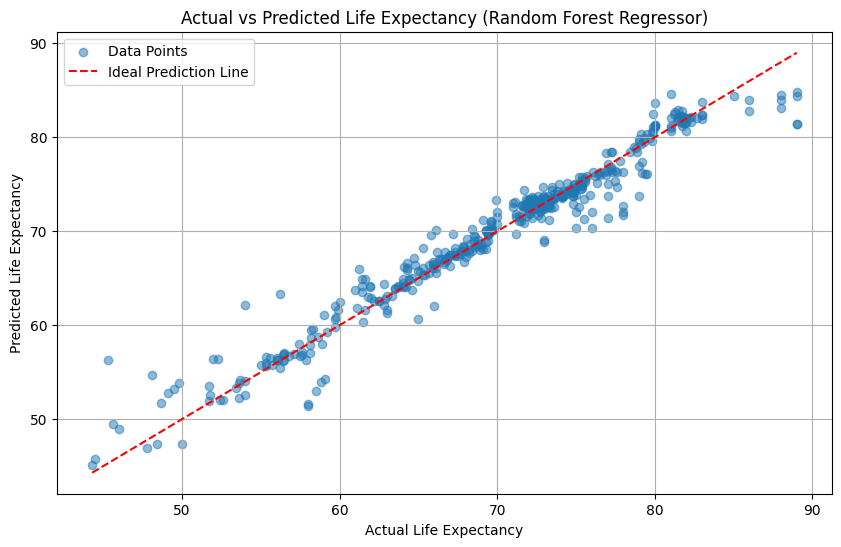

In [21]:
# Convert predictions and actual values to Pandas DataFrame for plotting
predictions_df = predictions.select("prediction").toPandas()
actuals_df = predictions.select("Life expectancy").toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(actuals_df["Life expectancy"], predictions_df["prediction"], alpha=0.5, label='Data Points')
plt.plot([min(actuals_df["Life expectancy"]), max(actuals_df["Life expectancy"])],
         [min(actuals_df["Life expectancy"]), max(actuals_df["Life expectancy"])],
         linestyle='--', color='red', label='Ideal Prediction Line')
plt.title('Actual vs Predicted Life Expectancy (Random Forest Regressor)')
plt.xlabel('Actual Life Expectancy')
plt.ylabel('Predicted Life Expectancy')
plt.grid(True)
plt.legend()
plt.show()

### Linear Regression

In [22]:
# Split the data into training and testing sets
train, test = df_vectorized.randomSplit([0.7, 0.3], seed=42)

# Define the Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="Life expectancy")

# Fit the model on training data
model = lr.fit(train)

# Make predictions on test data
predictions = model.transform(test)

# Calculate evaluation metrics
evaluator = RegressionEvaluator(labelCol="Life expectancy", predictionCol="prediction")

# Calculate accuracy within 5 years
predictions_df["Life expectancy"] = actuals_df["Life expectancy"]
predictions_df["within_5_years"] = np.abs(predictions_df["Life expectancy"] - predictions_df["prediction"]) <= 5
accuracy_within_5_years = predictions_df["within_5_years"].mean() * 100
print(f"Accuracy within 5 years: {accuracy_within_5_years:.2f}%")

Accuracy within 5 years: 96.62%


In [23]:
# Calculate RMSE
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MAE
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate R2
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
print(f"R-squared (R2): {r2}")

Root Mean Squared Error (RMSE): 3.72156813183793
Mean Absolute Error (MAE): 2.884323000169041
R-squared (R2): 0.826103861189522


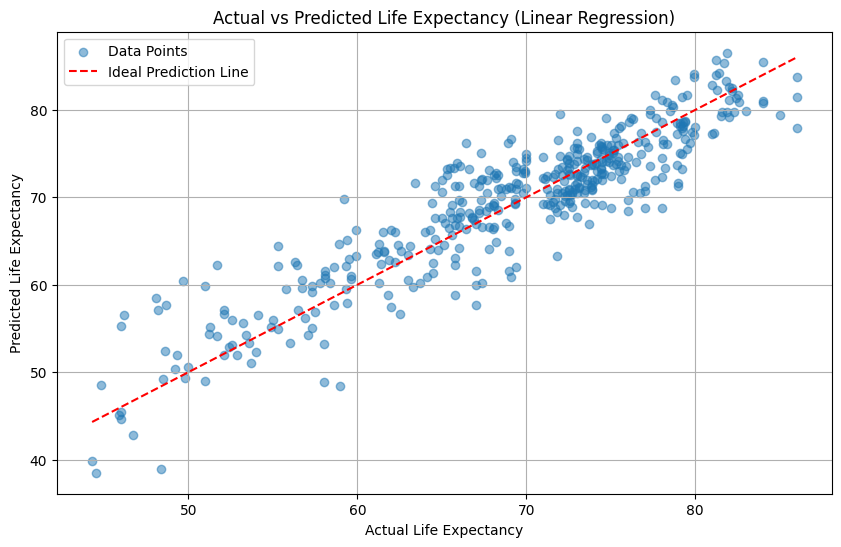

In [24]:
# Convert predictions and actual values to Pandas DataFrame for plotting
predictions_df = predictions.select("prediction").toPandas()
actuals_df = predictions.select("Life expectancy").toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(actuals_df["Life expectancy"], predictions_df["prediction"], alpha=0.5, label='Data Points')
plt.plot([min(actuals_df["Life expectancy"]), max(actuals_df["Life expectancy"])],
         [min(actuals_df["Life expectancy"]), max(actuals_df["Life expectancy"])],
         linestyle='--', color='red', label='Ideal Prediction Line')
plt.title('Actual vs Predicted Life Expectancy (Linear Regression)')
plt.xlabel('Actual Life Expectancy')
plt.ylabel('Predicted Life Expectancy')
plt.grid(True)
plt.legend()
plt.show()

### Polynomial Regression

In [25]:
# Split the data into training and testing sets
train, test = df_vectorized.randomSplit([0.7, 0.3], seed=42)

# Define the Polynomial Expansion transformer
poly_expansion = PolynomialExpansion(degree=2, inputCol="features", outputCol="poly_features")

# Define the Linear Regression model
lr = LinearRegression(featuresCol="poly_features", labelCol="Life expectancy")

# Create a Pipeline combining Polynomial Expansion and Linear Regression
pipeline = Pipeline(stages=[poly_expansion, lr])

# Fit the pipeline on training data
model = pipeline.fit(train)

# Make predictions on test data
predictions = model.transform(test)

# Calculate evaluation metrics
evaluator = RegressionEvaluator(labelCol="Life expectancy", predictionCol="prediction")

# Calculate accuracy within 5 years
predictions_df = predictions.select("prediction").toPandas()
actuals_df = predictions.select("Life expectancy").toPandas()

predictions_df["Life expectancy"] = actuals_df["Life expectancy"]
predictions_df["within_5_years"] = np.abs(predictions_df["Life expectancy"] - predictions_df["prediction"]) <= 5
accuracy_within_5_years = predictions_df["within_5_years"].mean() * 100
print(f"Accuracy within 5 years: {accuracy_within_5_years:.2f}%")

Accuracy within 5 years: 90.77%


In [26]:
# Calculate RMSE
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MAE
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate R2
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
print(f"R-squared (R2): {r2}")

Root Mean Squared Error (RMSE): 4.257334803598918
Mean Absolute Error (MAE): 2.33573443756041
R-squared (R2): 0.7724307380657622


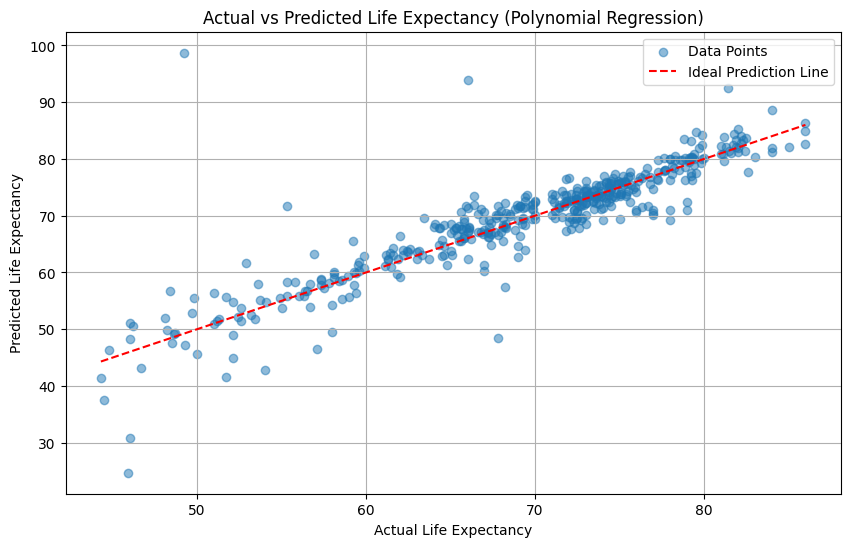

In [27]:
# Convert predictions and actual values to Pandas DataFrame for plotting
predictions_df = predictions.select("prediction").toPandas()
actuals_df = predictions.select("Life expectancy").toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(actuals_df["Life expectancy"], predictions_df["prediction"], alpha=0.5, label='Data Points')
plt.plot([min(actuals_df["Life expectancy"]), max(actuals_df["Life expectancy"])],
         [min(actuals_df["Life expectancy"]), max(actuals_df["Life expectancy"])],
         linestyle='--', color='red', label='Ideal Prediction Line')
plt.title('Actual vs Predicted Life Expectancy (Polynomial Regression)')
plt.xlabel('Actual Life Expectancy')
plt.ylabel('Predicted Life Expectancy')
plt.grid(True)
plt.legend()
plt.show()